In [1]:
import pandas as pd
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from xgboost import XGBClassifier
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from matplotlib import pyplot as plt
import numpy as np
import os
from scipy.sparse import hstack

file_path = "/Users/jessedimarzo/Downloads/Resume.csv"

resume_data = pd.read_csv(file_path)

resume_data.head(5)

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [2]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Convert text to lowercase, remove special characters, numbers, and punctuation, 
# remove extra whitespace, using the built in python library re.

In [3]:
resume_data['Cleaned_Resume_str'] = resume_data['Resume_str'].apply(clean_text)
# Apply the created cleaning function to the Resume_str column in the dataset

In [4]:
print(resume_data['ID'].is_unique)
# Just to confirm that the ID is a unique identifier, which the output of "True" confirmed. 
# The ID column is unnecessary for the analysis and modeling we will be performing, 
# and thus will be removed at this stage in the cleaning process.

True


In [5]:
# Drop the ID column as stated
resume_data = resume_data.drop(columns=['ID'])

# To confirm the column is removed
print(resume_data.head())

                                          Resume_str  \
0           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
1           HR SPECIALIST, US HR OPERATIONS      ...   
2           HR DIRECTOR       Summary      Over 2...   
3           HR SPECIALIST       Summary    Dedica...   
4           HR MANAGER         Skill Highlights  ...   

                                         Resume_html Category  \
0  <div class="fontsize fontface vmargins hmargin...       HR   
1  <div class="fontsize fontface vmargins hmargin...       HR   
2  <div class="fontsize fontface vmargins hmargin...       HR   
3  <div class="fontsize fontface vmargins hmargin...       HR   
4  <div class="fontsize fontface vmargins hmargin...       HR   

                                  Cleaned_Resume_str  
0  hr administratormarketing associate hr adminis...  
1  hr specialist us hr operations summary versati...  
2  hr director summary over years experience in r...  
3  hr specialist summary dedicated driven and dyn...

# Exploratory Data Analysis (EDA)

In [6]:
category_counts = resume_data['Category'].value_counts()
print(category_counts)

Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
ADVOCATE                  118
CHEF                      118
ENGINEERING               118
ACCOUNTANT                118
FINANCE                   118
FITNESS                   117
AVIATION                  117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64


The above code provides the count of each job category present in the dataset. The purpose of this is to check for imbalances in the data, as this could lead to biased classification models, which could perform poorly on underrepresented categories.

From the output, the top categories are INFORMATION-TECHNOLOGY and BUSINESS-DEVELOPMENT, both containing 120 resumes. Many of the other categories are right below 120, with the top 15 categories(by count) all within 10 resumes of the top two.

There are a few underrepresented categories, specifically in AGRICULTURE (63 resumes), AUTOMOBILE (36 resumes), and BPO (22 resumes). Clearly, there is a significant imbalance in these categories compared to the others, which could affect classification model performance. To combat this class imbalance, techniques such as stratified train-test splits will ensure that all categories are represented proportionally.

The imbalances are shown in the following bar charts:

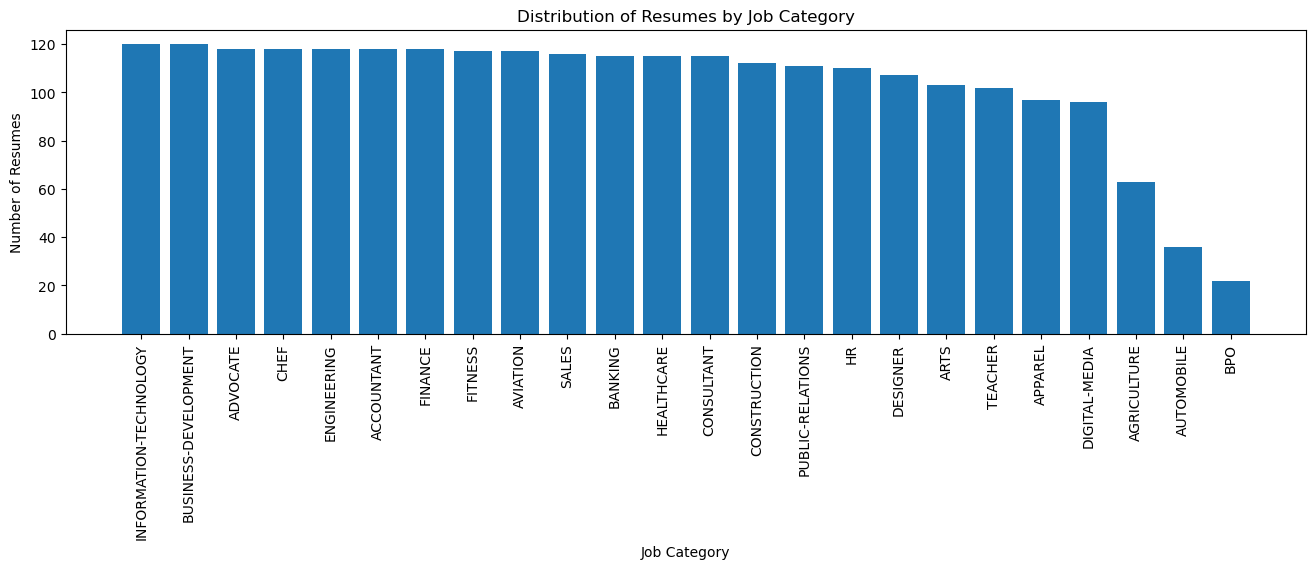

In [7]:
plt.figure(figsize=(16, 8))
plt.bar(category_counts.index, category_counts.values)
plt.title('Distribution of Resumes by Job Category')
plt.xlabel('Job Category')
plt.ylabel('Number of Resumes')
plt.xticks(rotation=90)
plt.subplots_adjust(bottom=0.5)
plt.show()

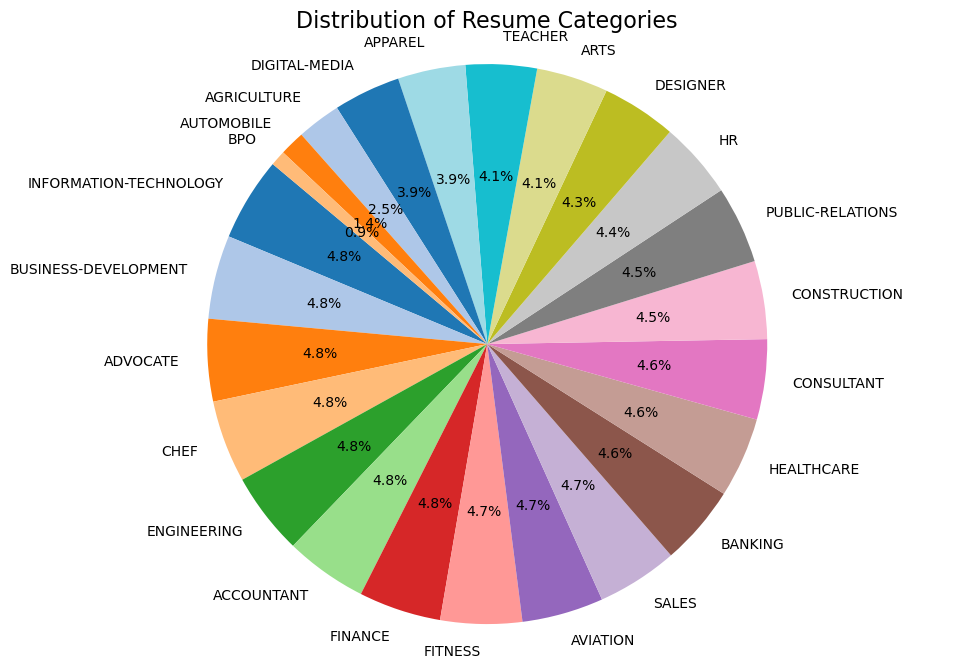

In [8]:
plt.figure(figsize=(12, 8))
category_counts = resume_data['Category'].value_counts()
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
plt.title('Distribution of Resume Categories', fontsize=16)
plt.axis('equal')
plt.show()

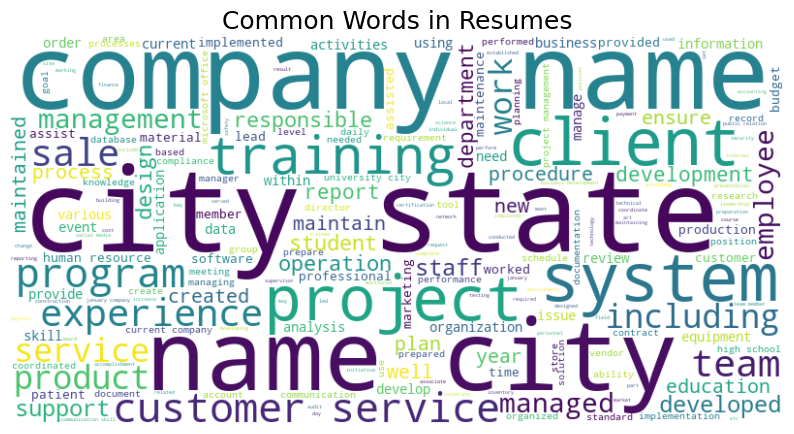

In [9]:
text_data = " ".join(resume_data['Cleaned_Resume_str'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Resumes', fontsize=18)
plt.show()

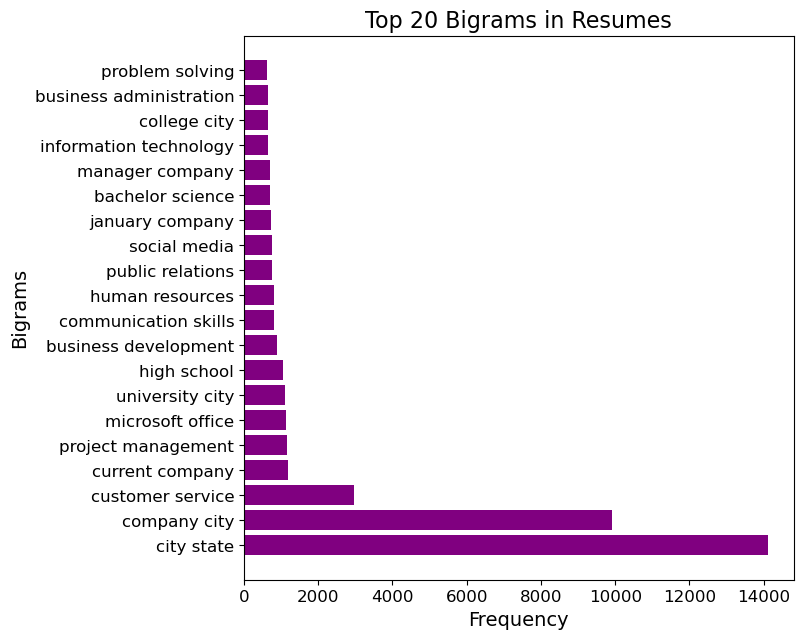

In [10]:
# Generate bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', max_features=20)
bigrams = vectorizer.fit_transform(resume_data['Cleaned_Resume_str'])

# Get bigram frequencies
bigram_df = pd.DataFrame({
    'bigram': vectorizer.get_feature_names_out(),
    'count': bigrams.sum(axis=0).A1
}).sort_values(by='count', ascending=False)

# Extract bigram labels and frequencies
bigram_labels = bigram_df['bigram']
bigram_freq = bigram_df['count']

# Plot the bigram frequencies
plt.figure(figsize=(10, 8))
plt.barh(bigram_labels, bigram_freq, color="purple")
plt.title("Top 20 Bigrams in Resumes", fontsize=16)
plt.xlabel("Frequency", fontsize=14)
plt.ylabel("Bigrams", fontsize=14)

plt.subplots_adjust(left=0.35)
plt.subplots_adjust(bottom=0.2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

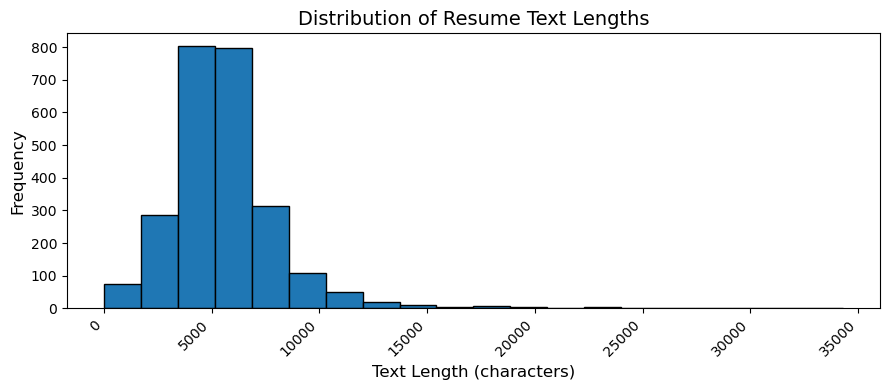

In [11]:
resume_data['Text_Length'] = resume_data['Cleaned_Resume_str'].apply(len)

plt.figure(figsize=(9, 4))
plt.hist(resume_data['Text_Length'], bins=20, edgecolor='black')
plt.title('Distribution of Resume Text Lengths', fontsize=14)
plt.xlabel('Text Length (characters)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

The above code aids in examining variability in the length of resumes. It appears that visually, the distribution of resume text lengths is approximately normal, although there may be extreme outliers as seen in the 25000 and 35000 character length resumes. This is just another part of the EDA, to gain a better understanding of the resumes as a whole.


In [12]:
it_resumes = resume_data[resume_data['Category'] == 'INFORMATION-TECHNOLOGY']
common_words = Counter(" ".join(it_resumes['Cleaned_Resume_str']).split()).most_common(20)
print(common_words)

[('and', 6827), ('to', 2767), ('of', 2329), ('the', 2319), ('for', 1520), ('in', 1210), ('with', 977), ('management', 890), ('a', 876), ('information', 854), ('technology', 735), ('systems', 734), ('support', 666), ('network', 656), ('state', 636), ('company', 617), ('city', 613), ('system', 577), ('project', 557), ('data', 543)]


In [13]:
aviation_resumes = resume_data[resume_data['Category'] == 'BPO']
common_words1 = Counter(" ".join(aviation_resumes['Cleaned_Resume_str']).split()).most_common(30)
print(common_words1)

[('and', 1097), ('to', 555), ('the', 533), ('of', 509), ('for', 361), ('in', 358), ('with', 221), ('a', 212), ('management', 202), ('company', 125), ('team', 124), ('on', 123), ('as', 116), ('city', 116), ('name', 115), ('business', 107), ('state', 105), ('process', 98), ('client', 95), ('customer', 87), ('service', 84), ('by', 82), ('sales', 79), ('support', 75), ('operations', 73), ('all', 73), ('new', 71), ('that', 67), ('network', 66), ('training', 63)]


In [14]:
aviation_resumes = resume_data[resume_data['Category'] == 'AVIATION']
common_words2 = Counter(" ".join(aviation_resumes['Cleaned_Resume_str']).split()).most_common(30)
print(common_words2)

[('and', 5758), ('to', 2345), ('of', 2069), ('the', 1670), ('for', 1176), ('in', 1146), ('with', 823), ('a', 724), ('state', 641), ('city', 604), ('on', 534), ('as', 523), ('company', 521), ('management', 519), ('training', 472), ('aviation', 462), ('name', 440), ('all', 392), ('maintenance', 388), ('aircraft', 356), ('systems', 342), ('skills', 333), ('customer', 319), ('equipment', 312), ('safety', 311), ('i', 285), ('or', 281), ('by', 277), ('work', 269), ('experience', 268)]


The counter package from the collections library is quite useful to see the most frequent words in each category. By doing so, we get a general idea of which words may be distinct between categories. For example, in INFORMATION-TECHNOLOGY, we see that technology, systems, and network are extremely frequent words, and in AVIATION, aircraft, state, city are very common. While this step provides insights into distinctions between categories, it reveals some issues that may arise for the machine learning. These two categories are vastly different, yet 'management' and 'system' are highly used in both, potentially exposing opportunity for confusion between the two categories.

In [15]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
tfidf_matrix_ngram = vectorizer.fit_transform(resume_data['Cleaned_Resume_str'])

The purpose of this feature engineering is to transform textual data into numerical features for modeling. The "Cleaned_Resume_str" column is converted into a sparse of TF-IDF scores, capturing the importance of certain words within each category.

In [16]:
label_encoder = LabelEncoder()
resume_data['Category_Label'] = label_encoder.fit_transform(resume_data['Category'])

Encoding job categories into numeric labels is crucial to allow for machine learning. Here, each category is labeled as an integer counting from 0 onward.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    tfidf_matrix_ngram, resume_data['Category_Label'], test_size=0.2, stratify=resume_data['Category_Label'], random_state=4188
)

To begin modeling, the data is split into a training and testing split, using a traditional 80/20 split. This stratified sampling will ensure a proportional representation of categories in both sets.


In [18]:
log_reg_model = LogisticRegression(max_iter=1000, random_state=4188)
log_reg_model.fit(X_train, y_train)

y_pred = log_reg_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6720321931589537

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.92      0.85        24
           1       0.46      0.71      0.56        24
           2       0.60      0.23      0.33        13
           3       0.80      0.42      0.55        19
           4       0.36      0.19      0.25        21
           5       1.00      0.14      0.25         7
           6       0.90      0.83      0.86        23
           7       0.75      0.65      0.70        23
           8       0.00      0.00      0.00         4
           9       0.58      0.88      0.70        24
          10       0.91      0.83      0.87        24
          11       0.94      0.77      0.85        22
          12       0.29      0.17      0.22        23
          13       0.76      0.76      0.76        21
          14       0.80      0.63      0.71        19
          15       0.66      0.96      0.78        24
          16       0.73    

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


A baseline logistic regression was conducted to see where the model is at in its current state, with its current features. The model is trained on the TF_IDF features, and provides performance evaluations to determine the precision, recall, and F1 score of the model.

As you can see, the numbers are not bad, but not great either.

In [19]:
log_reg_weighted_model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=4188)

log_reg_weighted_model.fit(X_train, y_train)

y_pred_weighted = log_reg_weighted_model.predict(X_test)

print("Accuracy with class weighting:", accuracy_score(y_test, y_pred_weighted))
print("\nClassification Report:\n", classification_report(y_test, y_pred_weighted))

Accuracy with class weighting: 0.6720321931589537

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.92      0.83        24
           1       0.64      0.67      0.65        24
           2       0.56      0.38      0.45        13
           3       0.57      0.42      0.48        19
           4       0.42      0.24      0.30        21
           5       0.20      0.29      0.24         7
           6       0.90      0.83      0.86        23
           7       0.83      0.65      0.73        23
           8       0.40      0.50      0.44         4
           9       0.59      0.83      0.69        24
          10       0.91      0.83      0.87        24
          11       0.94      0.77      0.85        22
          12       0.25      0.13      0.17        23
          13       0.79      0.71      0.75        21
          14       0.75      0.63      0.69        19
          15       0.68      0.96      0.79        24
      

To begin the trial and error of improving the model, this model addresses class imbalance by using weighted logistic regression. Essentially, this assigns higher weights to underrepresented classes to improve their recall. This was deemed necessary because of the lower macro avg in the previous model, showing that underrepresented classes had poor performance.

The updated model with balanced weight classes improved accuracy slightly compared to the previous one, but not by much. Category 5 and 8, which previously had zeros across the report, improved to non-zero precision, recall, and F1 scores, showing some improvements. Nonetheless, challenges persist with many low scores across categories.

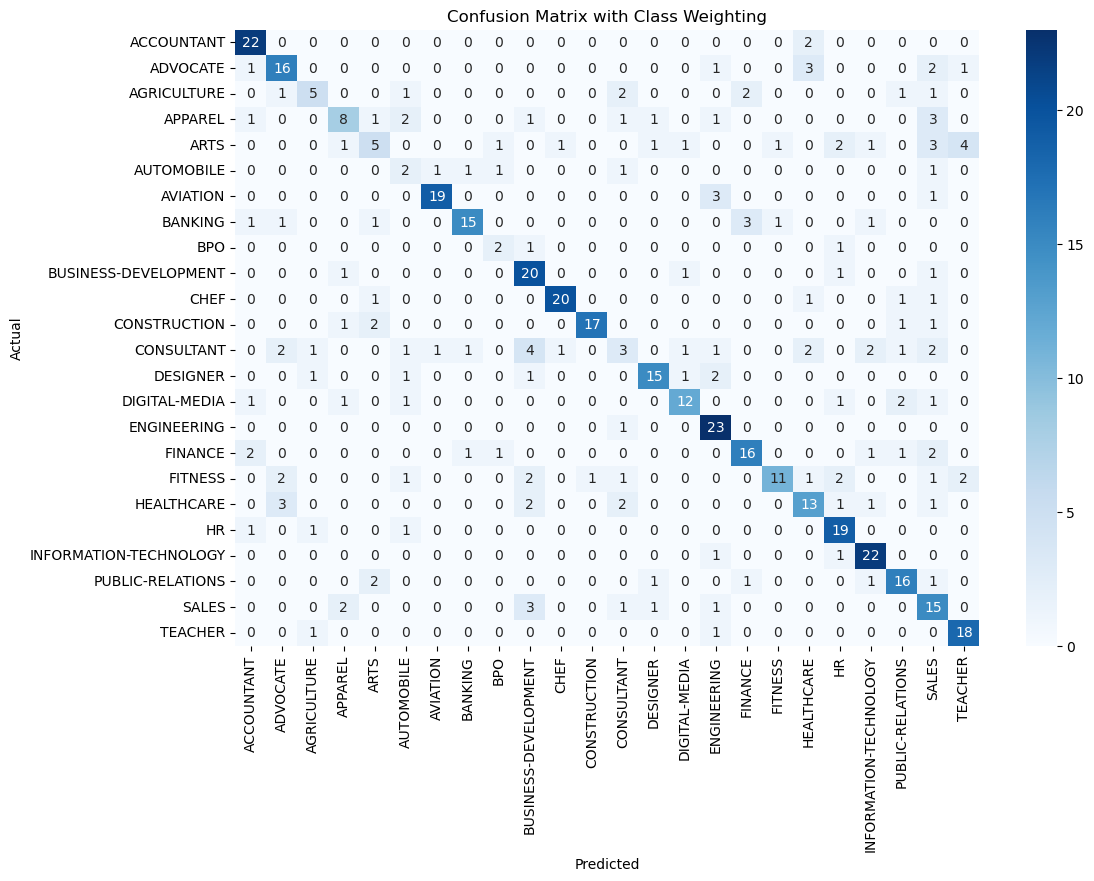

In [20]:
conf_matrix_weighted = confusion_matrix(y_test, y_pred_weighted)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix_weighted, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix with Class Weighting')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Upon trial and error to improve the logistic regression model, only slight improvements could be made, with methods such as SMOTE, and n-grams being utilized. The accuracy for each attempt to improve the model remained at around 65-67%. For this reason, other models will be pursued, and a Random Forest model will be created in the next step.

In [21]:
# Check the shape of the new TF-IDF matrix
print("TF-IDF Matrix Shape with N-Grams:", tfidf_matrix_ngram.shape)

TF-IDF Matrix Shape with N-Grams: (2484, 5000)


In [22]:
rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=4188)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.7766599597585513

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.96      0.85        24
           1       0.86      0.79      0.83        24
           2       1.00      0.31      0.47        13
           3       0.89      0.42      0.57        19
           4       0.56      0.24      0.33        21
           5       0.67      0.29      0.40         7
           6       0.91      0.87      0.89        23
           7       0.71      0.74      0.72        23
           8       0.00      0.00      0.00         4
           9       0.87      0.83      0.85        24
          10       0.88      0.96      0.92        24
          11       0.88      0.95      0.91        22
          12       0.71      0.74      0.72        23
          13       0.81      1.00      0.89        21
          14       0.93      0.68      0.79        19
          15       0.71      0.92      0.80        24

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


As can be seen in in the above classification report, accuracy increased from 65-67% to 77% with Random Forest, and the weighted average F1-score improved to 76%, indicating a better balance between precision and recall across all classes.

In [23]:
rf_model = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=4188)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.7746478873239436

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.96      0.87        24
           1       0.86      0.75      0.80        24
           2       0.83      0.38      0.53        13
           3       1.00      0.42      0.59        19
           4       0.62      0.24      0.34        21
           5       0.60      0.43      0.50         7
           6       0.88      0.91      0.89        23
           7       0.74      0.74      0.74        23
           8       0.00      0.00      0.00         4
           9       0.83      0.79      0.81        24
          10       0.88      0.96      0.92        24
          11       0.88      1.00      0.94        22
          12       0.71      0.65      0.68        23
          13       0.80      0.95      0.87        21
          14       0.93      0.74      0.82        19
          15       0.76      0.92      0.83        24

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Increasing the number of estimators to 200 increased overall accuracy to \~79% in a different random seed, but in this one it appears that the accuracy had not really changed. 300 and 400 estimators were tested to see if they improved the scores, but they either remained the same, or decreased. Thus, 200 appears to be the optimal number of estimators.

In [24]:
xgb_model = XGBClassifier(random_state=4188)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 0.7927565392354124

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.96      0.90        24
           1       0.76      0.92      0.83        24
           2       0.86      0.46      0.60        13
           3       0.82      0.47      0.60        19
           4       0.71      0.48      0.57        21
           5       0.57      0.57      0.57         7
           6       0.91      0.91      0.91        23
           7       0.74      0.61      0.67        23
           8       0.75      0.75      0.75         4
           9       0.87      0.83      0.85        24
          10       1.00      0.96      0.98        24
          11       0.83      0.91      0.87        22
          12       0.63      0.74      0.68        23
          13       0.73      0.90      0.81        21
          14       0.82      0.74      0.78        19
          15       0.70      0.88      0.78        24
          16       

To continue the process of trial and error of different models and hyperparameters, an XGBoost model demonstrated significant performance improvements compared to the previous models. The model improved to an accuracy of \~79%, and an F1-score of \~79%, indicating a better balance between precision and recall.

In [25]:
xgb_model_optimized = XGBClassifier(
    n_estimators=150,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.9,
    colsample_bytree=0.9,
    gamma=1,
    min_child_weight=2,
    random_state=4188
)
xgb_model_optimized.fit(X_train, y_train)
y_pred_optimized = xgb_model_optimized.predict(X_test)

print("Optimized XGBoost Accuracy:", accuracy_score(y_test, y_pred_optimized))
print("\nOptimized XGBoost Classification Report:\n", classification_report(y_test, y_pred_optimized))

Optimized XGBoost Accuracy: 0.7887323943661971

Optimized XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.83      1.00      0.91        24
           1       0.78      0.88      0.82        24
           2       0.83      0.38      0.53        13
           3       0.80      0.42      0.55        19
           4       0.71      0.48      0.57        21
           5       0.50      0.43      0.46         7
           6       0.95      0.91      0.93        23
           7       0.78      0.61      0.68        23
           8       1.00      0.25      0.40         4
           9       0.86      0.79      0.83        24
          10       0.96      0.96      0.96        24
          11       0.81      0.95      0.88        22
          12       0.62      0.70      0.65        23
          13       0.78      1.00      0.88        21
          14       0.78      0.74      0.76        19
          15       0.68      0.88      0.76  

Hyperparameters were chosen and implemented using logical approaches, e.g., balancing model complexity and regularization by adjusting parameters like max_depth, gamma, and min_child_weight, while improving generalization with a lower learning_rate combined with an increased n_estimators. These decisions reflect standard practices for optimizing XGBoost models to prevent overfitting and enhance predictive performance. An actual GridSearch or RandomSearch would prove more effective, which will be discussed later.

In [27]:
category_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}

for category_number, category_name in category_mapping.items():
    print(f"Category {category_number}: {category_name}")

Category 0: ACCOUNTANT
Category 1: ADVOCATE
Category 2: AGRICULTURE
Category 3: APPAREL
Category 4: ARTS
Category 5: AUTOMOBILE
Category 6: AVIATION
Category 7: BANKING
Category 8: BPO
Category 9: BUSINESS-DEVELOPMENT
Category 10: CHEF
Category 11: CONSTRUCTION
Category 12: CONSULTANT
Category 13: DESIGNER
Category 14: DIGITAL-MEDIA
Category 15: ENGINEERING
Category 16: FINANCE
Category 17: FITNESS
Category 18: HEALTHCARE
Category 19: HR
Category 20: INFORMATION-TECHNOLOGY
Category 21: PUBLIC-RELATIONS
Category 22: SALES
Category 23: TEACHER


A legend to interpret the classification report easier, and understand which categories were classified well, and which struggled.

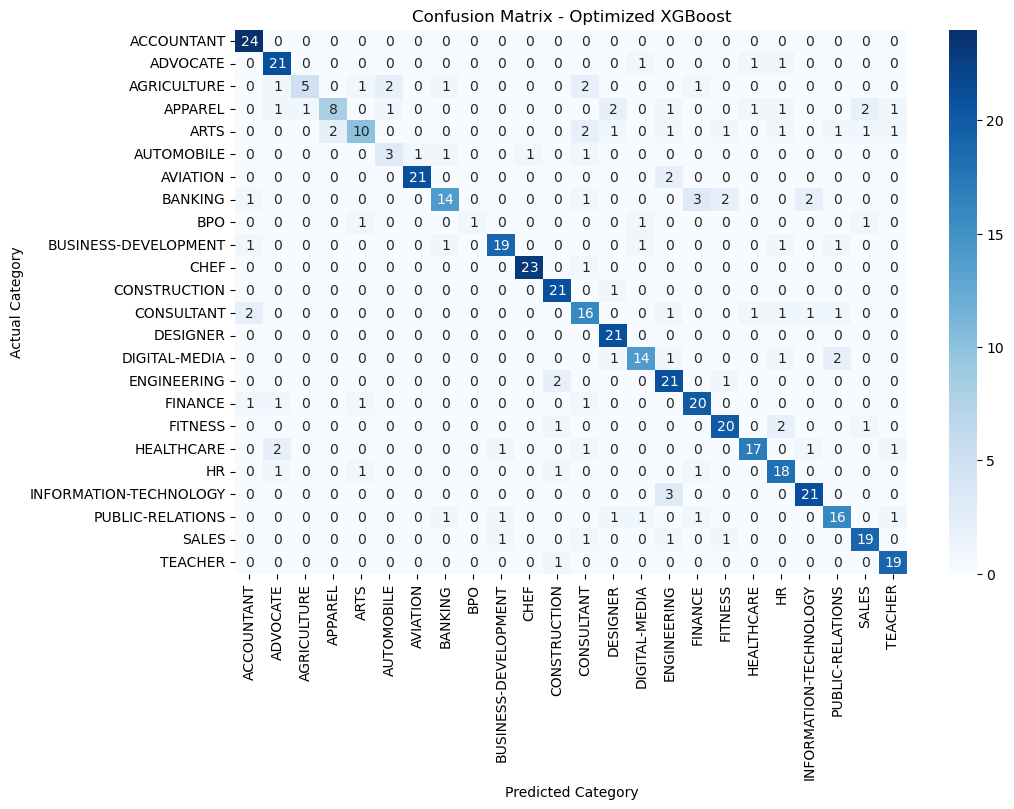

In [30]:
conf_matrix = confusion_matrix(y_test, y_pred_optimized)

category_labels = [category_mapping[i] for i in range(len(category_mapping))]

plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=category_labels, 
            yticklabels=category_labels)
plt.title('Confusion Matrix - Optimized XGBoost')
plt.xlabel('Predicted Category')
plt.ylabel('Actual Category')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.subplots_adjust(left=0.2)
plt.subplots_adjust(bottom=0.2)

plt.show()

In [29]:
## Get feature importance
importance = xgb_model_optimized.feature_importances_
indices = np.argsort(importance)[-10:]  # Top 10 features
feature_names = vectorizer.get_feature_names_out()

# Display top 10 features
print("Top 10 Important Features:")
for i in indices:
    print(f"{feature_names[i]}: {importance[i]}")

Top 10 Important Features:
teacher: 0.006178727839142084
advocate: 0.006286573596298695
designer: 0.00654153386130929
fitness: 0.0069027733989059925
aviation: 0.0069129737094044685
accountant: 0.007474720012396574
information technology: 0.0075397067703306675
exercise: 0.0075677563436329365
chef: 0.007890306413173676
public relations: 0.008322834968566895
